In [79]:
#importing the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [80]:
# Importing the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [81]:
# Chekcing the type of the data for trainning set
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [82]:
# Chekcing the type of the data for trainning set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


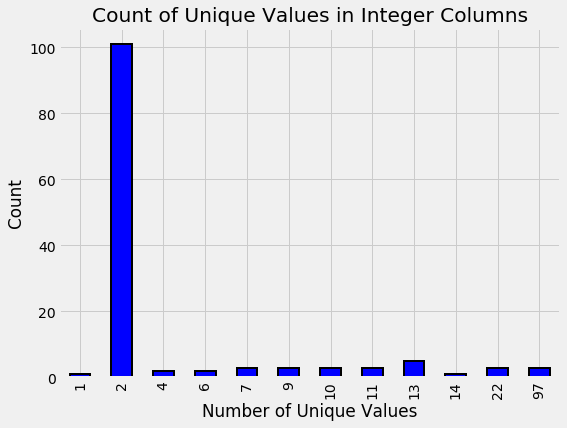

In [83]:
#Interger column
train.select_dtypes(np.int64).nunique().value_counts().sort_index()
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color = 'blue', 
                                                                             figsize = (8, 6),
                                                                            edgecolor = 'k', linewidth = 2);
plt.xlabel('Number of Unique Values'); plt.ylabel('Count');
plt.title('Count of Unique Values in Integer Columns');

C:\Users\NR\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


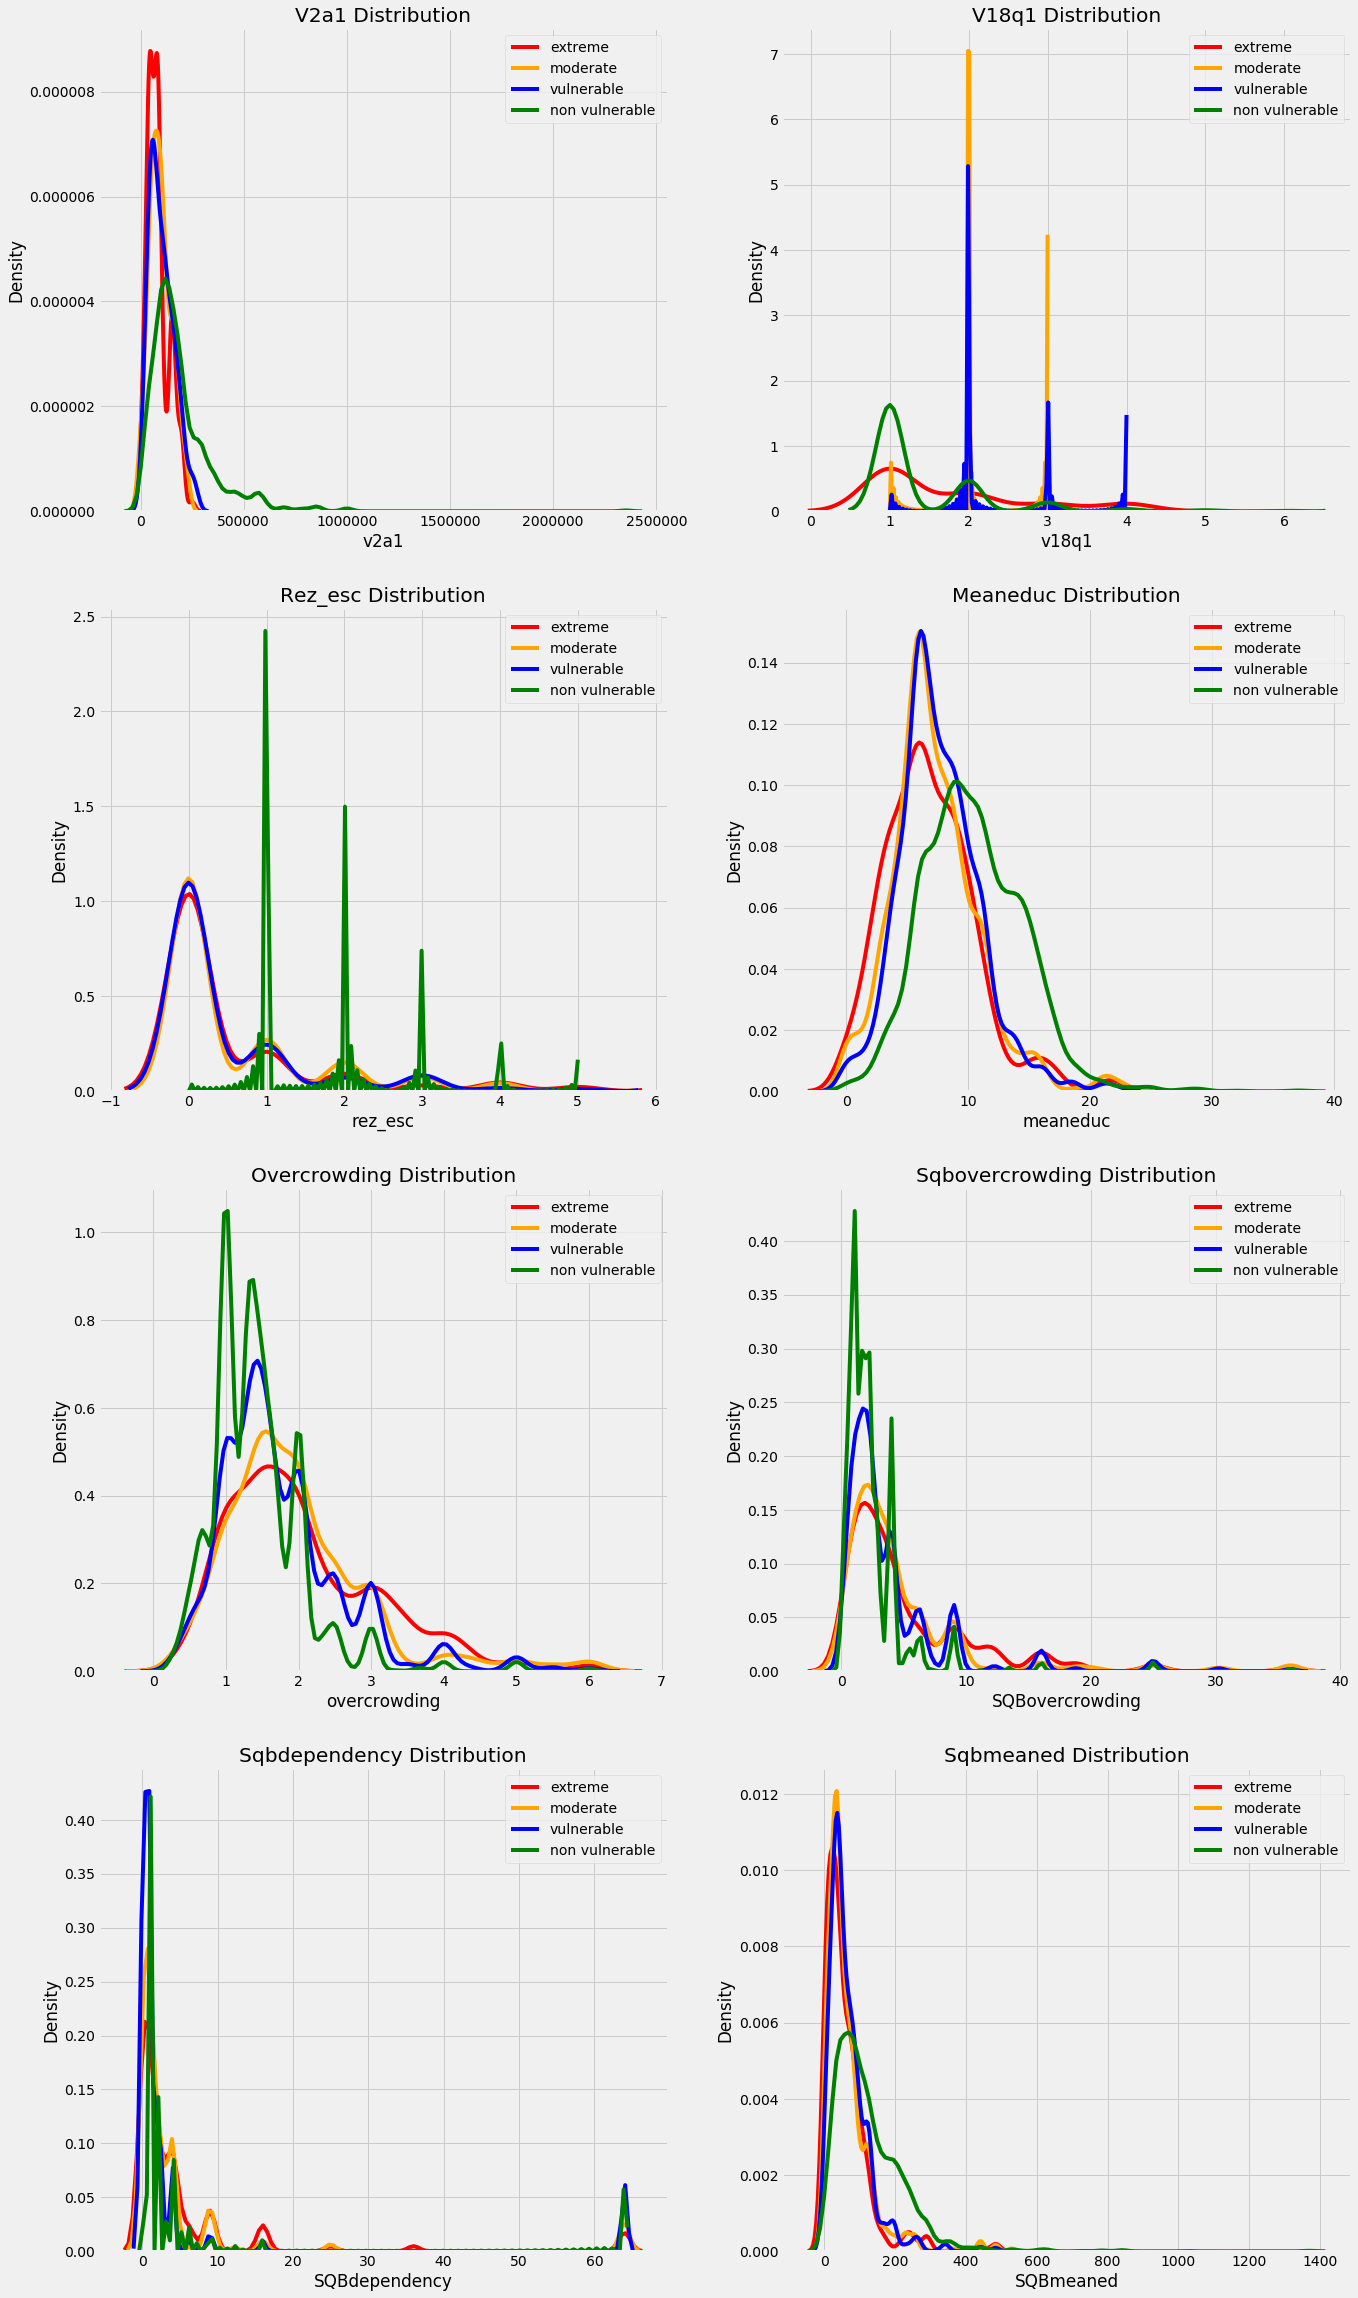

In [84]:
#flote column
from collections import OrderedDict
import seaborn as sns

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)


In [85]:
# object column 
train.select_dtypes('object').head()

mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()


,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


In [86]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)


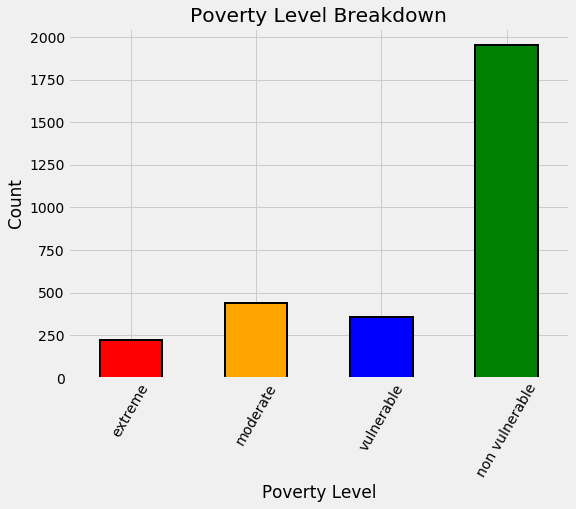

In [87]:
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)
# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');


In [88]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


In [89]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [90]:
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

0 Households with no head have different labels.


In [91]:

# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


In [92]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


In [93]:
data['rez_esc'] = data['rez_esc'].fillna(0)

In [94]:
data['v18q1'] = data['v18q1'].fillna(0)

In [95]:
data['v2a1'] = data['v2a1'].fillna(0)

In [96]:
data['SQBmeaned'] = data['SQBmeaned'].fillna(0)

In [97]:
data['meaneduc'] = data['meaneduc'].fillna(0)

In [98]:
data.isna().sum()

Id                     0
v2a1                   0
hacdor                 0
rooms                  0
hacapo                 0
v14a                   0
refrig                 0
v18q                   0
v18q1                  0
r4h1                   0
r4h2                   0
r4h3                   0
r4m1                   0
r4m2                   0
r4m3                   0
r4t1                   0
r4t2                   0
r4t3                   0
tamhog                 0
tamviv                 0
escolari               0
rez_esc                0
hhsize                 0
paredblolad            0
paredzocalo            0
paredpreb              0
pareddes               0
paredmad               0
paredzinc              0
paredfibras            0
                   ...  
bedrooms               0
overcrowding           0
tipovivi1              0
tipovivi2              0
tipovivi3              0
tipovivi4              0
tipovivi5              0
computer               0
television             0


In [109]:
#separating the variable
train_X = np.array(list(data[data['Target'].notnull()]['Target'].astype(np.uint8)))
train_y = data[data['Target'].notnull()].drop(columns = ['Id', 'idhogar', 'Target'])
test_y = data[data['Target'].isnull()].drop(columns = ['Id', 'idhogar', 'Target'])

In [111]:
#Fitting the model
from sklearn.ensemble import RandomForestClassifier
classifier =  RandomForestClassifier(n_estimators=100, random_state=10)

In [117]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
cv_score = cross_val_score(classifier, train_y, train_X, cv = 10,scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.342 with std = 0.0401
